# Load libraries and Data

In [29]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# dWeb Checkout Migration test

In [32]:
# latest ramp period
start_date = '2022-04-29'
end_date = '2022-05-04'
test_name = 'mp_checkout_dweb_v2'
control = 'control'
treatment = 'treatment'
device_cat = "('Personal computer')" 
# device_cat = "('Tablet','Smartphone')"
tmp_user_table1 = 'wandajuan.visitor_base_' + test_name
tmp_user_table2 = 'wandajuan.mp_metrics_' + test_name
tmp_user_table4 = 'wandajuan.xo_metrics_' + test_name
tmp_user_table5 = 'wandajuan.xo_funnel_action_' + test_name
tmp_user_table3 = 'wandajuan.' + test_name

## User Base

In [8]:
# Test user base:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table1} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_user_table1=tmp_user_table1,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,1902


In [7]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_user_table1} group by 1 order by 1""".format(tmp_user_table1=tmp_user_table1),conn)

,test_variant,_col1
0,control,978
1,treatment,922
2,treatment_qa,2


with or without dedup, total # visitors in manual pull is less than abdash, which is 1041+987+2 

In [37]:
test_users = pd.read_sql('select * from {tmp_user_table1}'.format(tmp_user_table1=tmp_user_table1), conn)
test_users

,visitor_id,test_variant,dt
0,eae7d9a8-a895-4a01-9c17-36c51f5a087a,control,2022-04-29
1,5d7b5269-f9fb-4dce-8a75-aa285ea63549,control,2022-04-30
2,601cac81-2008-4af1-9d59-9a9e58a48c6e,treatment,2022-05-04
3,3b3b624b-71d8-4130-a29e-7bbd418de30a,control,2022-05-03
4,f6c8fe1d-e38f-4536-bdb3-f1987e7f9358,control,2022-05-02
...,...,...,...
1897,08cc5dab-eacc-416f-8bc2-d5b37cf1d880,control,2022-04-29
1898,e6db31c1-9e7c-47f6-b351-a57ee935798d,treatment,2022-04-29
1899,3baf2914-26e3-45ad-86c9-4e81e0b0521c,treatment,2022-05-02
1900,7c510f87-dfc0-4d06-84bd-46bf4dce02d0,treatment,2022-05-01


## MP table

In [80]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
pd.read_sql('drop table {tmp_user_table2}'.format(tmp_user_table2=tmp_user_table2), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table2} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_user_table1} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0 
  -- and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table2 = tmp_user_table2,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,2217


In [197]:
# mp = pd.read_sql("select * from {tmp_user_table2}".format(tmp_user_table2=tmp_user_table2), conn)
# mp

## XO Table

In [ ]:
# Checkout Metrics:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table4} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_user_table1} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table4 = tmp_user_table4,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

In [198]:
# xo = pd.read_sql("select * from {tmp_user_table4}".format(tmp_user_table4 = tmp_user_table4), conn)
# xo

## XO funnel actions

In [34]:

# Checkout funnel with sign in status at the time:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table5} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*,
	coalesce(json_extract_scalar(action_metadata, '$.app'), json_extract_scalar(action_metadata, '$.originatingPageData["app"]'))  app,
	coalesce(json_extract_scalar(action_metadata, '$.isUserSignedIn'), json_extract_scalar(action_metadata, '$.originatingPageData["isUserSignedIn"]'))  isUserSignedIn	
from {tmp_user_table1} t0
join l2.user_action_daily t2
on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and (t2.action like '%CHECKOUT%' 
--or t2.action like '%CART%'
or t2.action like '%SIGN%')
-- GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table5 = tmp_user_table5,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,11661


In [199]:
# xo_action = pd.read_sql("select * from {tmp_user_table5}".format(tmp_user_table5=tmp_user_table5), conn)
# xo_action

## Final Table

In [82]:
# Final Table:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table3} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from wandajuan.xo_metrics_mp_checkout_dweb_v2 sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from wandajuan.mp_metrics_mp_checkout_dweb_v2 va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_user_table4=tmp_user_table4,
           tmp_user_table3=tmp_user_table3,
            tmp_user_table2=tmp_user_table2,
            tmp_user_table1=tmp_user_table1,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in impala:


,rows
0,2544


In [83]:
# df = pd.read_sql('select * from {tmp_user_table3}'.format(tmp_user_table3=tmp_user_table3), conn)
# df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-02,control,b141ac88-d2be-49c1-b5e3-02b63b4329ad,0.0,10.0,0.0,30.0,3.0,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-03,control,6713edec-9622-4556-bc7b-185391abf405,0.0,0.0,0.0,18.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,458.00,458.00,139.39,139.39,1.0,0.0,1.0,0.0,0.0,0.0,458.00,0.0,0.0,0.0
2,2022-04-30,treatment,9ce77fa7-acec-4af0-8e28-e79d26cc6662,0.0,4.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-03,treatment,4e4e64c8-fdc5-4490-81bb-ad9eb0423a9e,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-02,control,b3e7ef0d-a940-4d6f-bd82-2dc89cf71640,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2022-04-29,treatment,f706353f-74a4-49c5-8e78-e14ab8080c81,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,364.00,364.00,101.02,101.02,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,364.0,0.0
2540,2022-04-29,control,6f8bc8a9-2742-4ecc-b222-7372bf849cc9,4.0,17.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541,2022-05-04,treatment,1a5a60f4-00d5-4b5d-a760-911f3033182d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2542,2022-05-03,control,95152ff5-8bc6-4387-bff3-7cd2b0b3df00,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,542.44,542.44,97.64,97.64,1.0,0.0,1.0,0.0,0.0,0.0,542.44,0.0,0.0,0.0


# Helper functions

In [127]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [110]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)]['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)]['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# Analysis

## User distribution

In [84]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control         978
treatment       922
treatment_qa      2
Name: visitor_id, dtype: int64

In [85]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,treatment,treatment_qa
dt,,,
2022-04-29,149.0,127.0,NaN
2022-04-30,167.0,182.0,NaN
2022-05-01,184.0,184.0,NaN
2022-05-02,254.0,234.0,NaN
2022-05-03,286.0,215.0,2.0
2022-05-04,271.0,288.0,1.0


<AxesSubplot:xlabel='dt'>

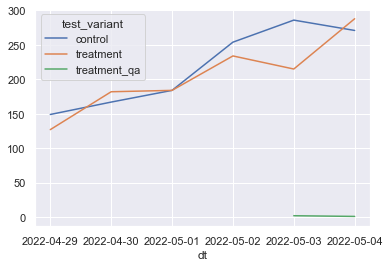

In [86]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [101]:
# exclude qa
df = df.loc[df['test_variant']!='treatment_qa']

In [104]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
777,2022-05-02,control,2856711b-9cf9-4610-80e4-47dbb5ddce19,10786.00
670,2022-05-04,control,0f6c8cce-c53e-4e56-9c53-f7abb7d105d3,6271.80
715,2022-05-02,control,d8627356-1afe-49b9-a949-304dfc6708e1,5165.68
617,2022-04-30,control,3f3d4ec3-1b93-455a-b703-c65bfbaec5f9,4704.00
2132,2022-05-03,control,a26a4172-ef37-441c-8d5c-ec699732d522,4554.70
...,...,...,...,...
2536,2022-05-04,control,ce2bcd67-fd0f-4ba4-83e4-db95032a744c,NaN
2538,2022-05-02,treatment,c262ef6f-763a-44fe-8cc3-31f2df21f821,NaN
2540,2022-04-29,control,6f8bc8a9-2742-4ecc-b222-7372bf849cc9,NaN
2541,2022-05-04,treatment,1a5a60f4-00d5-4b5d-a760-911f3033182d,NaN


In [105]:
# excluding 1 large order
df = df.loc[df['order_gmv']<10000]

In [106]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

browse_products  view_product  cart_add  view_cart  \
dt         test_variant                                                       
2022-04-29 control              5.024096      7.024096  1.662651   1.662651   
           treatment            4.224138      4.482759  1.224138   1.448276   
2022-04-30 control              6.916667      9.571429  1.380952   2.071429   
           treatment            5.488889      8.011111  1.355556   1.311111   
2022-05-01 control              5.717391      6.663043  1.434783   1.521739   
...                                  ...           ...       ...        ...   
2022-05-02 treatment            4.010989      6.362637  1.450549   1.670330   
2022-05-03 control              6.010000      6.270000  1.350000   2.020000   
           treatment            4.800000      5.171429  1.257143   1.128571   
2022-05-04 control              4.927928      5.189189  1.324324   1.531532   
           treatment            5.409524      7.304762  1.457143   1.238095   

                         checkout_launch  checkout_shipping  \
dt         test_variant                                       
2022-04-29 control              1.277108           1.096386   
           treatment            1.603448           0.775862   
2022-04-30 control              1.416667           1.285714   
           treatment            1.577778           1.011111   
2022-05-01 control              1.467391           1.380435   
...                                  ...                ...   
2022-05-02 treatment            1.670330           1.109890   
2022-05-03 control              1.240000           1.080000   
           treatment            1.600000           0.957143   
2022-05-04 control              1.387387           1.090090   
           treatment            1.638095           1.057143   

                         checkout_billing_and_payment  checkout_order_review  \
dt         test_variant                                                        
2022-04-29 control                           1.024096               1.867470   
           treatment                         1.655172               1.051724   
2022-04-30 control                           1.142857               1.761905   
           treatment                         1.722222               1.155556   
2022-05-01 control                           0.989130               3.108696   
...                                               ...                    ...   
2022-05-02 treatment                         2.000000               1.208791   
2022-05-03 control                           1.020000               1.670000   
           treatment                         1.914286               1.157143   
2022-05-04 control                           0.873874               1.927928   
           treatment                         1.723810               1.323810   

                         checkout_order_confirmation    signup  order_numbers  \
dt         test_variant                                                         
2022-04-29 control                          1.000000  0.349398       1.325301   
           treatment                        1.086207  0.517241       1.275862   
2022-04-30 control                          1.023810  0.500000       1.190476   
           treatment                        1.077778  0.533333       1.200000   
2022-05-01 control                          1.054348  0.489130       1.228261   
...                                              ...       ...            ...   
2022-05-02 treatment                        1.076923  0.670330       1.241758   
2022-05-03 control                          1.020000  0.440000       1.210000   
           treatment                        1.028571  0.471429       1.257143   
2022-05-04 control                          1.009009  0.504505       1.180180   
           treatment                        1.161905  0.571429       1.257143   

                         units_sold   order_gmv  order_gmv_w_coupon  \
dt         

In [107]:
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-04-29,control,5.024096,7.024096,1.662651,1.662651,1.277108,1.096386,1.024096,1.867470,1.000000,0.349398,1.325301,3.108434,583.203373,579.408193,139.078364,135.283183,0.602410,0.722892,1.108434,0.0,0.012048,0.204819,497.592048,0.0,1.445783,84.165542
1,2022-04-29,treatment,4.224138,4.482759,1.224138,1.448276,1.603448,0.775862,1.655172,1.051724,1.086207,0.517241,1.275862,1.982759,641.461207,636.978448,141.709034,137.226276,0.758621,0.517241,1.086207,0.0,0.034483,0.155172,573.729310,0.0,14.172414,53.559483
2,2022-04-30,control,6.916667,9.571429,1.380952,2.071429,1.416667,1.285714,1.142857,1.761905,1.023810,0.500000,1.190476,1.976190,457.898333,452.990000,128.073900,123.165567,0.666667,0.523810,0.833333,0.0,0.000000,0.357143,347.021429,0.0,0.000000,110.876905
3,2022-04-30,treatment,5.488889,8.011111,1.355556,1.311111,1.577778,1.011111,1.722222,1.155556,1.077778,0.533333,1.200000,1.822222,439.432667,434.964000,107.398344,102.929678,0.633333,0.566667,0.955556,0.0,0.011111,0.233333,353.550000,0.0,2.400000,83.482667
4,2022-05-01,control,5.717391,6.663043,1.434783,1.521739,1.467391,1.380435,0.989130,3.108696,1.054348,0.489130,1.228261,1.913043,478.049130,475.331739,112.060043,109.342652,0.728261,0.500000,1.086957,0.0,0.010870,0.130435,428.317283,0.0,1.834565,47.897283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2022-05-02,treatment,4.010989,6.362637,1.450549,1.670330,1.670330,1.109890,2.000000,1.208791,1.076923,0.670330,1.241758,2.769231,477.730879,474.046264,126.034584,122.349968,0.802198,0.439560,0.989011,0.0,0.010989,0.241758,401.962308,0.0,2.692308,73.076264
8,2022-05-03,control,6.010000,6.270000,1.350000,2.020000,1.240000,1.080000,1.020000,1.670000,1.020000,0.440000,1.210000,1.910000,544.822300,540.122300,129.791172,125.091172,0.710000,0.500000,0.950000,0.0,0.030000,0.230000,444.335900,0.0,7.146100,93.340300
9,2022-05-03,treatment,4.800000,5.171429,1.257143,1.128571,1.600000,0.957143,1.914286,1.157143,1.028571,0.471429,1.257143,2.157143,613.237429,610.053143,154.440234,151.255949,0.757143,0.500000,1.114286,0.0,0.028571,0.114286,510.293000,0.0,5.414286,97.530143
10,2022-05-04,control,4.927928,5.189189,1.324324,1.531532,1.387387,1.090090,0.873874,1.927928,1.009009,0.504505,1.180180,2.342342,549.649459,542.724324,125.240835,118.315700,0.603604,0.576577,0.936937,0.0,0.000000,0.243243,410.977477,0.0,0.000000,138.671982


## Day to Day Metrics Plot

<ipython-input-133-f6f3f989c0b9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 4))


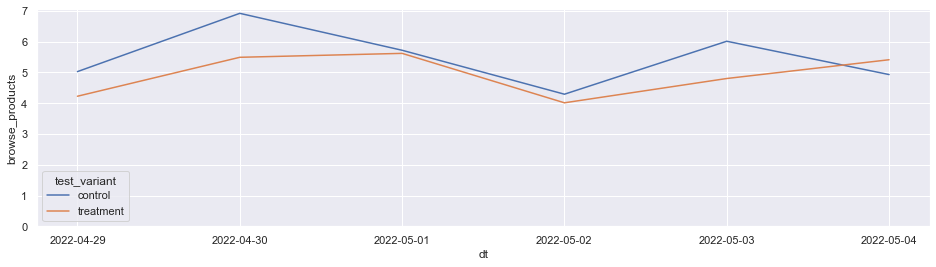

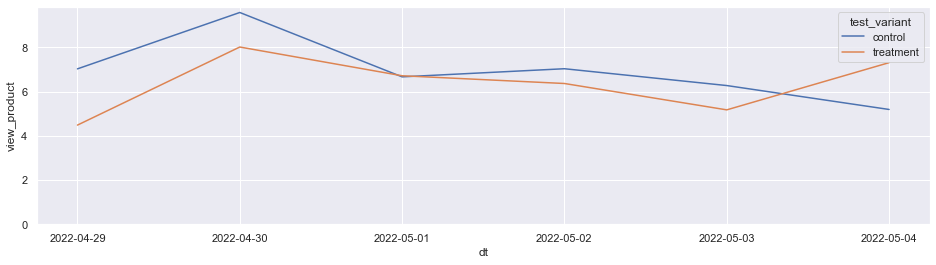

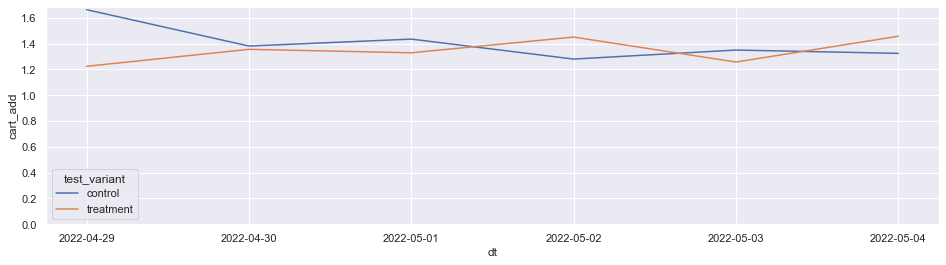

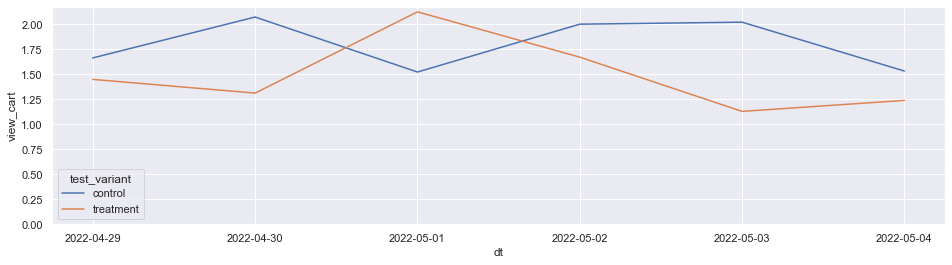

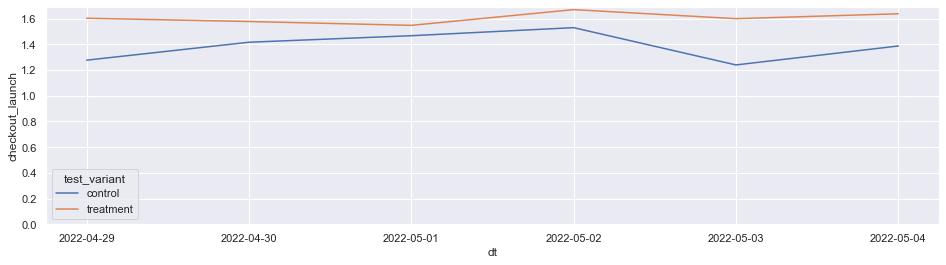

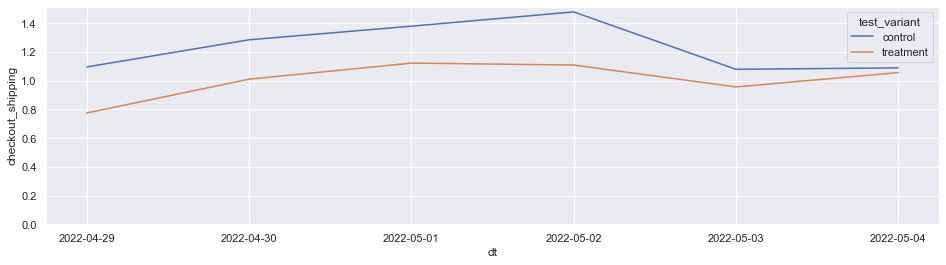

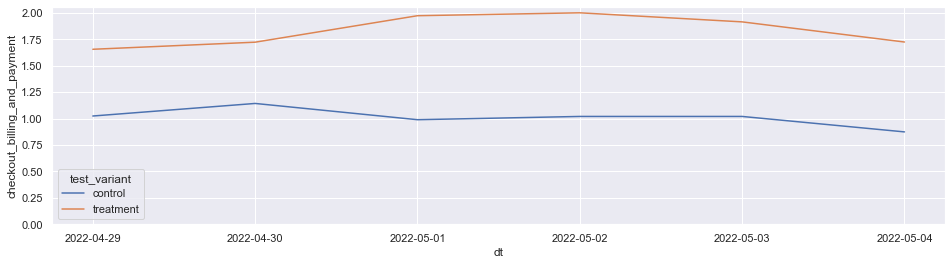

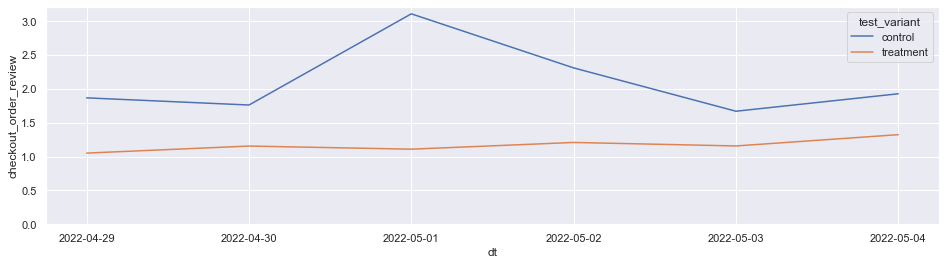

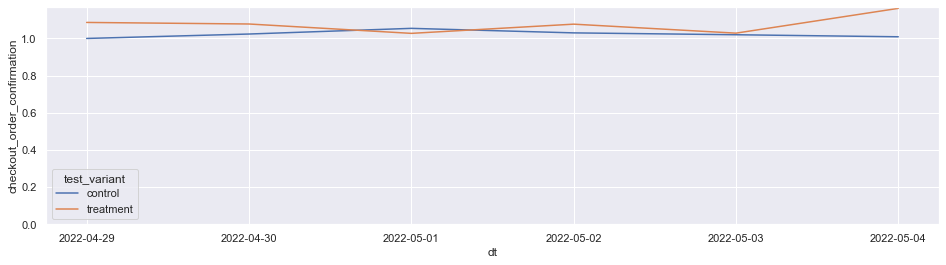

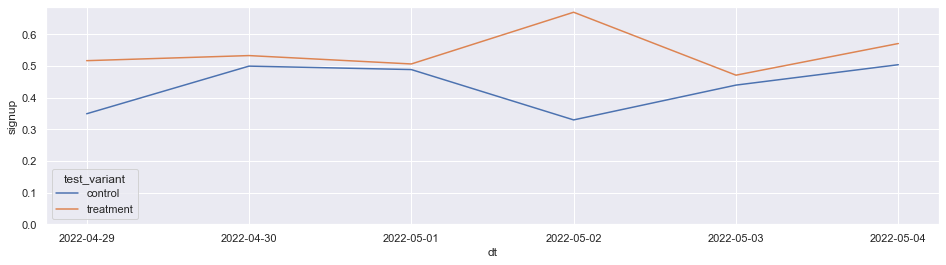

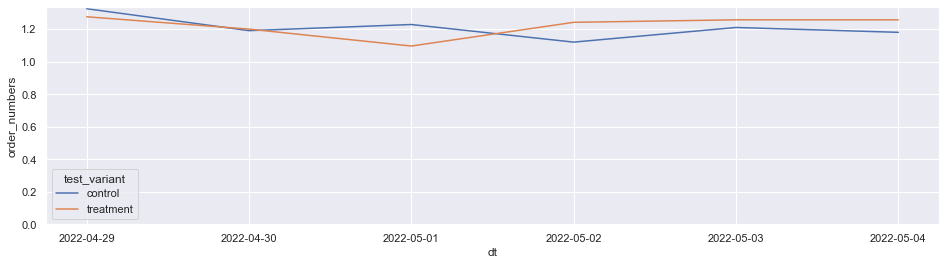

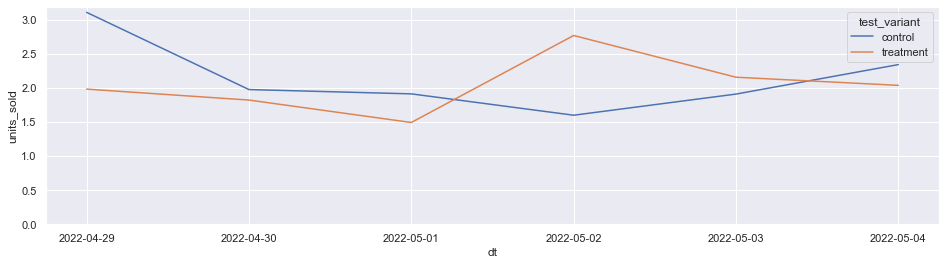

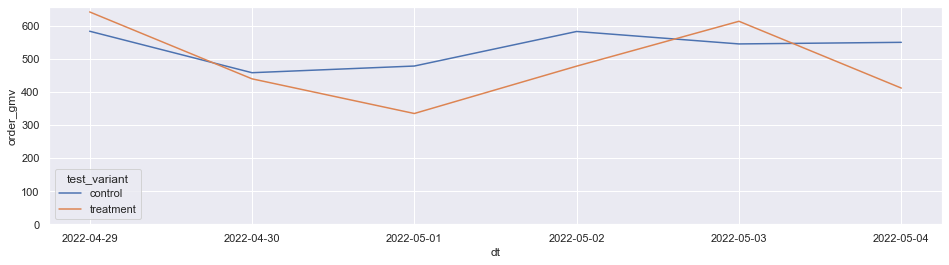

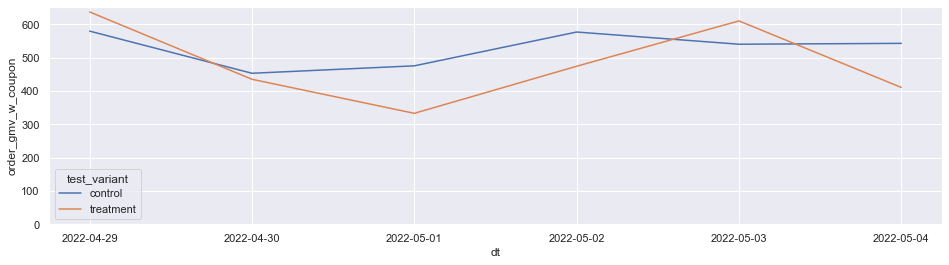

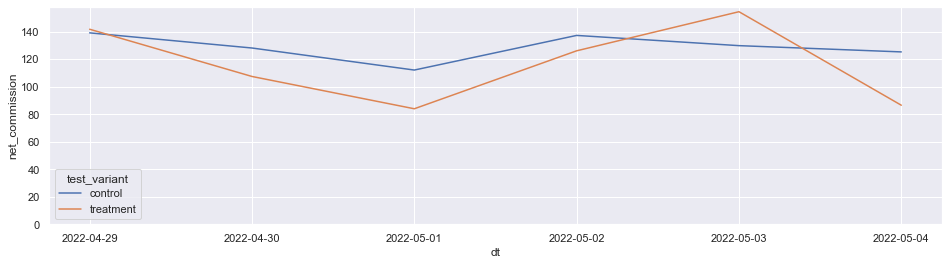

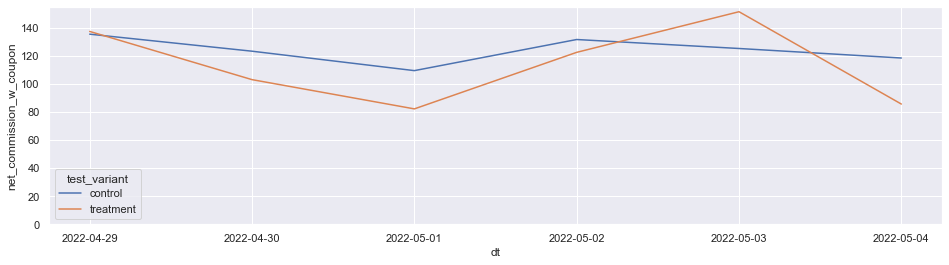

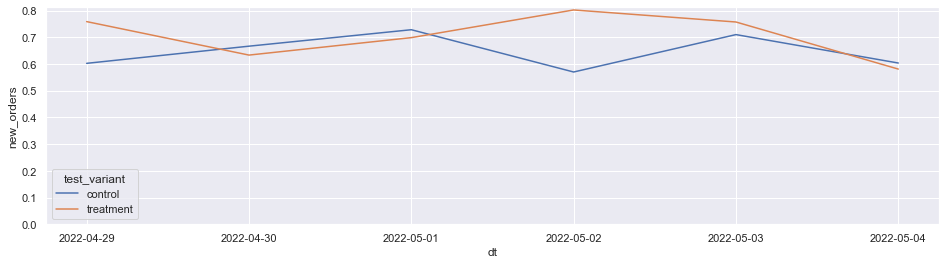

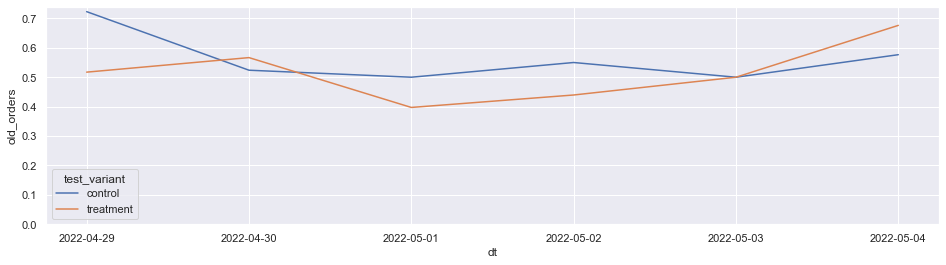

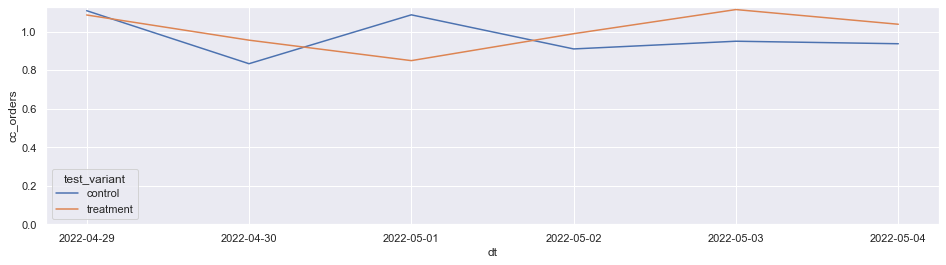

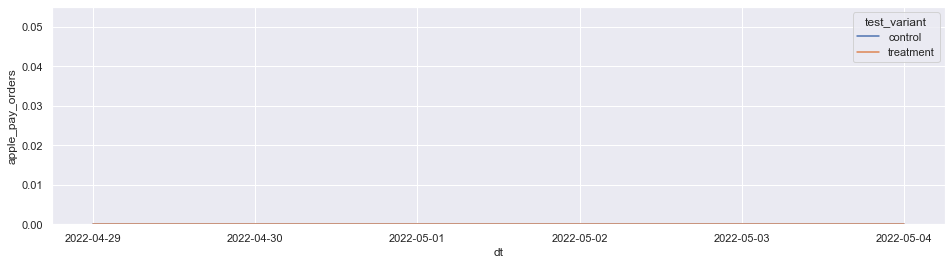

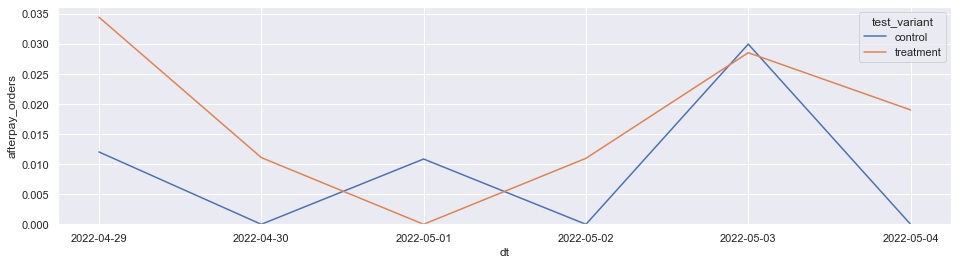

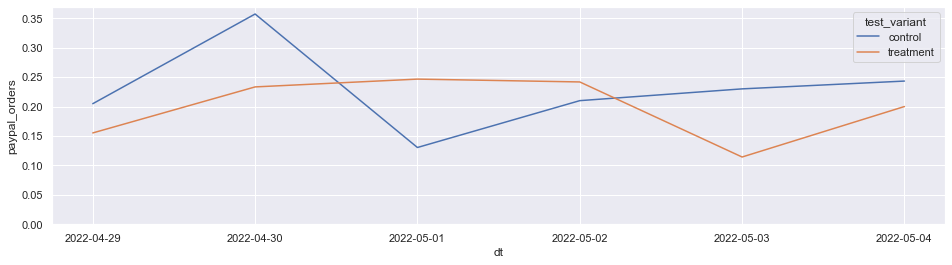

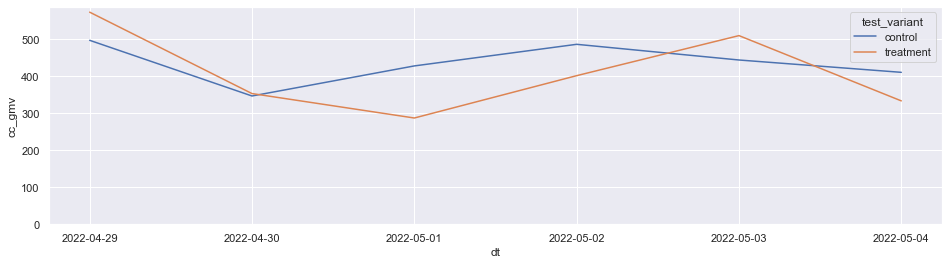

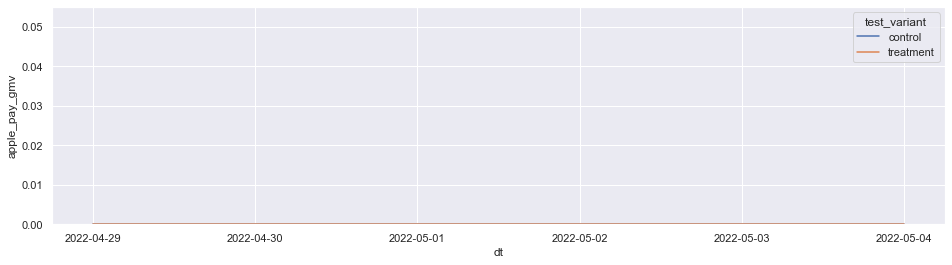

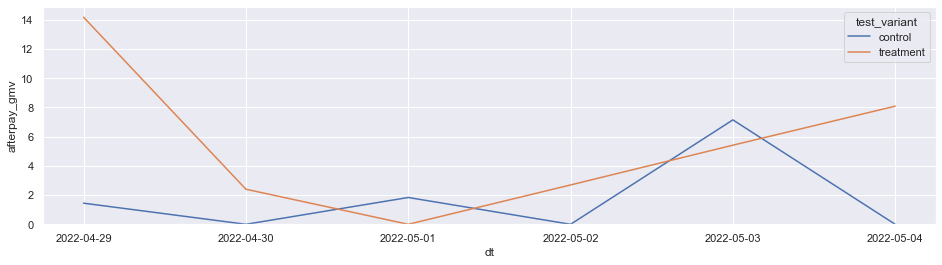

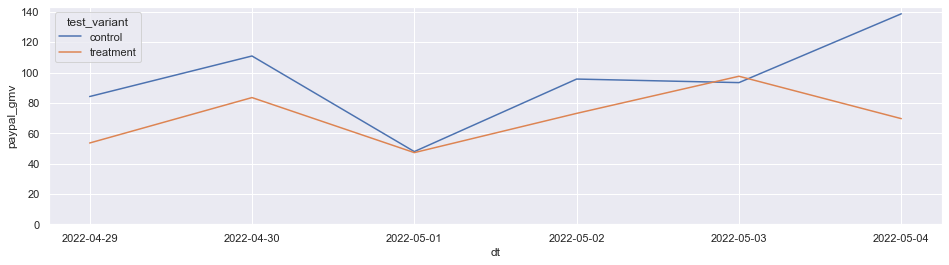

In [133]:
for metric in metrics:
    plt.figure(figsize=(16, 4))
    sns.lineplot(data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    plt.ylim(ymin=0)

## Metrics Summary

In [189]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from wandajuan.mp_checkout_dweb_v2
where order_gmv < 10000 or order_gmv is null
group by 1, 2
"""

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,control,64,10,71,64,18,40,12,8,6,10,7,3,9.0,13.0,7785.97,7785.97,1696.0100,1696.0100,3.0,6.0,9.0,0.0,0.0,0.0,7785.97,0.0,0.0,0.00
1,treatment,0,9,57,57,11,10,15,12,6,3,3,4,3.0,4.0,1121.13,1121.13,218.3200,218.3200,1.0,2.0,2.0,0.0,1.0,0.0,905.13,0.0,216.0,0.00
2,treatment,11,9,37,52,10,24,14,12,12,6,5,5,5.0,5.0,2423.59,2398.59,604.2960,579.2960,5.0,0.0,5.0,0.0,0.0,0.0,2423.59,0.0,0.0,0.00
3,treatment,92,8,113,108,18,15,16,9,8,6,6,3,6.0,6.0,3492.01,3492.01,924.5900,924.5900,4.0,2.0,5.0,0.0,0.0,1.0,3422.06,0.0,0.0,69.95
4,treatment,94,11,116,113,26,24,13,11,14,8,5,2,5.0,6.0,1037.00,997.00,247.0454,207.0454,4.0,1.0,2.0,0.0,1.0,2.0,438.00,0.0,458.0,141.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,treatment,70,11,33,62,10,19,18,9,10,8,4,3,6.0,19.0,3127.07,3127.07,624.8000,624.8000,3.0,3.0,2.0,0.0,0.0,4.0,554.83,0.0,0.0,2572.24
198,treatment,99,10,120,154,38,47,16,10,18,6,6,5,8.0,12.0,2676.02,2676.02,499.0100,499.0100,6.0,2.0,5.0,0.0,0.0,3.0,1333.02,0.0,0.0,1343.00
199,control,12,8,21,43,14,5,9,9,5,45,4,3,4.0,5.0,768.00,768.00,142.7800,142.7800,1.0,3.0,4.0,0.0,0.0,0.0,768.00,0.0,0.0,0.00
200,treatment,85,7,51,54,12,8,20,9,17,3,3,3,3.0,6.0,223.78,223.78,40.2900,40.2900,2.0,1.0,2.0,0.0,0.0,1.0,205.84,0.0,0.0,17.94


In [113]:
avg_col_list = ['avg_' + m for m in metrics]
avg_col_list

['avg_browse_products',
 'avg_view_product',
 'avg_cart_add',
 'avg_view_cart',
 'avg_checkout_launch',
 'avg_checkout_shipping',
 'avg_checkout_billing_and_payment',
 'avg_checkout_order_review',
 'avg_checkout_order_confirmation',
 'avg_signup',
 'avg_order_numbers',
 'avg_units_sold',
 'avg_order_gmv',
 'avg_order_gmv_w_coupon',
 'avg_net_commission',
 'avg_net_commission_w_coupon',
 'avg_new_orders',
 'avg_old_orders',
 'avg_cc_orders',
 'avg_apple_pay_orders',
 'avg_afterpay_orders',
 'avg_paypal_orders',
 'avg_cc_gmv',
 'avg_apple_pay_gmv',
 'avg_afterpay_gmv',
 'avg_paypal_gmv']

In [190]:
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv
0,control,64,10,71,64,18,40,12,8,6,10,7,3,9.0,13.0,7785.97,7785.97,1696.0100,1696.0100,3.0,6.0,9.0,0.0,0.0,0.0,7785.97,0.0,0.0,0.00,7.100000,6.400000,1.800000,4.000000,1.200000,0.800000,0.600000,1.000000,0.700000,0.300000,0.900000,1.300000,778.597000,778.597000,169.601000,169.601000,0.300000,0.600000,0.900000,0.0,0.000000,0.000000,778.597000,0.0,0.000000,0.000000
1,treatment,0,9,57,57,11,10,15,12,6,3,3,4,3.0,4.0,1121.13,1121.13,218.3200,218.3200,1.0,2.0,2.0,0.0,1.0,0.0,905.13,0.0,216.0,0.00,6.333333,6.333333,1.222222,1.111111,1.666667,1.333333,0.666667,0.333333,0.333333,0.444444,0.333333,0.444444,124.570000,124.570000,24.257778,24.257778,0.111111,0.222222,0.222222,0.0,0.111111,0.000000,100.570000,0.0,24.000000,0.000000
2,treatment,11,9,37,52,10,24,14,12,12,6,5,5,5.0,5.0,2423.59,2398.59,604.2960,579.2960,5.0,0.0,5.0,0.0,0.0,0.0,2423.59,0.0,0.0,0.00,4.111111,5.777778,1.111111,2.666667,1.555556,1.333333,1.333333,0.666667,0.555556,0.555556,0.555556,0.555556,269.287778,266.510000,67.144000,64.366222,0.555556,0.000000,0.555556,0.0,0.000000,0.000000,269.287778,0.0,0.000000,0.000000
3,treatment,92,8,113,108,18,15,16,9,8,6,6,3,6.0,6.0,3492.01,3492.01,924.5900,924.5900,4.0,2.0,5.0,0.0,0.0,1.0,3422.06,0.0,0.0,69.95,14.125000,13.500000,2.250000,1.875000,2.000000,1.125000,1.000000,0.750000,0.750000,0.375000,0.750000,0.750000,436.501250,436.501250,115.573750,115.573750,0.500000,0.250000,0.625000,0.0,0.000000,0.125000,427.757500,0.0,0.000000,8.743750
4,treatment,94,11,116,113,26,24,13,11,14,8,5,2,5.0,6.0,1037.00,997.00,247.0454,207.0454,4.0,1.0,2.0,0.0,1.0,2.0,438.00,0.0,458.0,141.00,10.545455,10.272727,2.363636,2.181818,1.181818,1.000000,1.272727,0.727273,0.454545,0.181818,0.454545,0.545455,94.272727,90.636364,22.458673,18.822309,0.363636,0.090909,0.181818,0.0,0.090909,0.181818,39.818182,0.0,41.636364,12.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,treatment,70,11,33,62,10,19,18,9,10,8,4,3,6.0,19.0,3127.07,3127.07,624.8000,624.8000,3.0,3.0,2.0,0.0,0.0,4.0,554.83,0.0,0.0,2572.24,3.000000,5.636364,0.909091,1.727273,1.636364,0.818182,0.909091,0.727273,0.363636,0.272727,0.545455,1.727273,284.279091,284.279091,56.800000,56.800000,0.272727,0.272727,0.181818,0.0,0.000000,0.363636,50.439091,0.0,0.000000,233.840000
198,treatment,99,10,120,154,38,47,16,10,18,6,6,5,8.0,12.0,2676.02,2676.02,499.0100,499.0100,6.0,2.0,5.0,0.0,0.0,3.0,1333.02,0.0,0.0,1343.00,12.000000,15.400000,3.800000,4.700000,1.600000,1.000000,1.800000,0.600000,0.600000,0.500000,0.800000,1.200000,267.602000,267.602000,49.901000,49.901000,0.600000,0.200000,0.500000,0.0,0.000000,0.300000,133.302000,0.0,0.000000,134.300000
199,control,12,8,21,43,14,5,9,9,5,45,4,3,4.0,5.0,768.00,768.00,142.7800,142.7800,1.0,3.0,4.0,0.0,0.0,0.0,768.00,0.0,0.0,0.00,2.625000,5.375000,1.750000,0.625000,1.125000,1.125000,0.625000,5.625000,0.500000,0.375000,0.500000,0.625000,96.000000,96.000000,17.847500,17.847500,0.125000,0.375000,0.50000

In [191]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_browse_products,922,4911.000000,5.3227,978,5267.000000,5.4022,-0.07954,-1.47%,0.8765
1,avg_view_product,922,7082.000000,7.7418,978,7277.000000,7.3432,0.39862,5.43%,0.4707
2,avg_cart_add,922,1364.000000,1.4964,978,1417.000000,1.4342,0.06225,4.34%,0.4181
3,avg_view_cart,922,1618.000000,1.7618,978,1764.000000,1.7375,0.02423,1.39%,0.8925
4,avg_checkout_launch,922,1538.000000,1.6703,978,1324.000000,1.3555,0.31480,23.22%,0.0000
5,avg_checkout_shipping,922,1027.000000,1.1061,978,1287.000000,1.3181,-0.21205,-16.09%,0.0003
6,avg_checkout_billing_and_payment,922,1278.000000,1.4148,978,798.000000,0.8239,0.59092,71.72%,0.0000
7,avg_checkout_order_review,922,736.000000,0.8098,978,1490.000000,1.5910,-0.78119,-49.10%,0.0000
8,avg_checkout_order_confirmation,922,541.000000,0.6048,978,599.000000,0.6212,-0.01646,-2.65%,0.5896
9,avg_signup,922,366.000000,0.4112,978,340.000000,0.3565,0.05460,15.31%,0.0992


## Slice by session level signin status

In [134]:
q = """
create table {tmp_user_table3}_by_signinstatus AS
with xo as (

select dt, test_variant, visitor_id, signin_status, session_id,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from wandajuan.xo_metrics_mp_checkout_dweb_v2 sm
group by 1, 2, 3, 4, 5

)
, mp as (

select 

		order_date, test_variant, visitor_id,
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from wandajuan.mp_metrics_mp_checkout_dweb_v2 va
 group by 1, 2, 3, 4
)
, xo_sign as (

select dt, visitor_id, session_id, cast(bool_or(cast(isusersignedin as boolean)) as int) + cast(bool_and(cast(isusersignedin as boolean)) as int) as signinstatus_xo
from wandajuan.xo_funnel_action_mp_checkout_dweb_v2
group by 1, 2, 3

)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		signinstatus_xo,
		
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
--on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
on xo.session_id = mp.session_id
left join xo_sign
on coalesce(mp.session_id, xo.session_id) = xo_sign.session_id

""".format(tmp_user_table3= tmp_user_table3)

pd.read_sql(q, conn)

,rows
0,4344


In [200]:
# df_sign

In [142]:
# two fields not completely corelated
df_sign[['signin_status', 'signinstatus_xo']].drop_duplicates()

,signin_status,signinstatus_xo
0,ALWAYS_SIGNED_IN,NaN
1,PARTIAL_SIGNED_IN,1.0
2,ALWAYS_SIGNED_IN,2.0
4,SIGNED_OUT,NaN
6,PARTIAL_SIGNED_IN,0.0
...,...,...
185,SIGNED_IN_MULTIPLE,0.0
188,SIGNED_IN_MULTIPLE,NaN
1423,SIGNED_IN_MULTIPLE,1.0
2647,ALWAYS_SIGNED_IN,1.0


In [192]:
# prepare data by slicing `signin_status`
q = """
select 
        signin_status, 
		--signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from wandajuan.mp_checkout_dweb_v2_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
"""

df_sign_ss = pd.read_sql(q, conn)

df_sign_ss

,signin_status,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,ALWAYS_SIGNED_IN,treatment,67,8,62.0,91.0,16.0,22.0,12.0,6.0,8.0,3.0,3.0,0.0,3.0,4.0,1160.00,1160.00,388.17,388.17,2.0,1.0,2.0,0.0,0.0,1.0,982.00,0.0,0.0,178.0
1,SIGNED_OUT,control,62,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SIGNED_OUT,control,1,8,31.0,82.0,9.0,6.0,4.0,5.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PARTIAL_SIGNED_IN,control,88,4,7.0,17.0,1.0,7.0,5.0,6.0,6.0,6.0,4.0,1.0,3.0,5.0,1238.17,1238.17,424.84,424.84,3.0,0.0,2.0,0.0,0.0,1.0,468.17,0.0,0.0,770.0
4,None,control,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,120.00,120.00,36.39,36.39,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,120.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,SIGNED_OUT,treatment,79,6,6.0,40.0,6.0,37.0,38.0,38.0,6.0,3.0,2.0,2.0,2.0,3.0,486.00,486.00,125.70,125.70,1.0,1.0,1.0,0.0,0.0,1.0,392.00,0.0,0.0,94.0
677,ALWAYS_SIGNED_IN,control,87,2,25.0,15.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,79.18,79.18,14.26,14.26,0.0,1.0,1.0,0.0,0.0,0.0,79.18,0.0,0.0,0.0
678,SIGNED_OUT,control,11,5,0.0,14.0,6.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679,ALWAYS_SIGNED_IN,control,89,5,2.0,32.0,2.0,5.0,8.0,8.0,4.0,7.0,1.0,0.0,1.0,1.0,1801.00,1761.00,500.02,460.02,1.0,0.0,1.0,0.0,0.0,0.0,1801.00,0.0,0.0,0.0


In [169]:
def metricSummary(df):
    df[avg_col_list] = df[metrics].div(df_all['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [201]:
df_sign_ss.groupby('signin_status').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', None)
df_sign_ss.groupby('signin_status').apply(metricSummary)#.style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

Metric Treatment Size  \
signin_status                                                            
ALWAYS_SIGNED_IN   0                avg_browse_products            312   
                   1                   avg_view_product            312   
                   2                       avg_cart_add            312   
                   3                      avg_view_cart            312   
                   4                avg_checkout_launch            312   
                   5              avg_checkout_shipping            312   
                   6   avg_checkout_billing_and_payment            312   
                   7          avg_checkout_order_review            312   
                   8    avg_checkout_order_confirmation            312   
                   9                         avg_signup            312   
                   10                 avg_order_numbers            312   
                   11                    avg_units_sold            312   
                   12                     avg_order_gmv            312   
                   13            avg_order_gmv_w_coupon            312   
                   14                avg_net_commission            312   
                   15       avg_net_commission_w_coupon            312   
                   16                    avg_new_orders            312   
                   17                    avg_old_orders            312   
                   18                     avg_cc_orders            312   
                   19              avg_apple_pay_orders            312   
                   20               avg_afterpay_orders            312   
                   21                 avg_paypal_orders            312   
                   22                        avg_cc_gmv            312   
                   23                 avg_apple_pay_gmv            312   
                   24                  avg_afterpay_gmv            312   
                   25                    avg_paypal_gmv            312   
PARTIAL_SIGNED_IN  0                avg_browse_products            296   
                   1                   avg_view_product            296   
                   2                       avg_cart_add            296   
                   3                      avg_view_cart            296   
                   4                avg_checkout_launch            296   
                   5              avg_checkout_shipping            296   
                   6   avg_checkout_billing_and_payment            296   
                   7          avg_checkout_order_review            296   
                   8    avg_checkout_order_confirmation            296   
                   9                         avg_signup            296   
                   10                 avg_order_numbers            296   
                   11                    avg_units_sold            296   
                   12                     avg_order_gmv            296   
                   13            avg_order_gmv_w_coupon            296   
                   14                avg_net_commission            296   
                   15       avg_net_commission_w_coupon            296   
                   16                    avg_new_orders            296   
                   17                    avg_old_orders            296   
                   18                     avg_cc_orders            296   
                   19              avg_apple_pay_orders            296   
                   20               avg_afterpay_orders            296   
                   21                 avg_paypal_orders            296   
                   22                        avg_cc_gmv            296   
                   23                 avg_apple_pay_gmv            296   
                   24                  avg_afterpay_gmv            296   
                   25                    avg_paypal_gmv            296   
SIGNED_IN_MULTIPLE 0                avg_browse_produc

## Slice by signin status upon checkout

In [194]:
# prepare data by slicing `signin_status`
q = """
select 
        --signin_status, 
		signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from wandajuan.mp_checkout_dweb_v2_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
"""

df_sign_xo = pd.read_sql(q, conn)

df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2.0,control,43,3,1,3,1,0,3,1,2,11,3,0,3.0,4.0,984.00,885.00,292.1900,193.1900,1.0,2.0,3.0,0.0,0.0,0.0,984.00,0.0,0.0,0.0
1,2.0,treatment,38,2,3,11,2,13,5,5,8,4,2,0,2.0,3.0,656.64,656.64,218.4400,218.4400,0.0,2.0,2.0,0.0,0.0,0.0,656.64,0.0,0.0,0.0
2,2.0,control,99,7,29,35,9,16,9,10,15,30,6,1,9.0,10.0,2372.19,2302.19,576.4484,506.4484,1.0,8.0,5.0,0.0,0.0,4.0,1134.89,0.0,0.0,1237.3
3,2.0,treatment,74,6,20,59,6,12,15,3,5,5,3,1,5.0,6.0,2203.99,2173.99,482.5300,452.5300,1.0,4.0,5.0,0.0,0.0,0.0,2203.99,0.0,0.0,0.0
4,0.0,control,99,4,1,12,4,1,4,6,4,10,2,1,2.0,2.0,172.30,172.30,45.2470,45.2470,2.0,0.0,2.0,0.0,0.0,0.0,172.30,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,control,81,6,12,30,5,7,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,2.0,treatment,78,1,14,4,3,0,2,0,0,1,1,0,3.0,3.0,1378.40,1378.40,378.2900,378.2900,0.0,3.0,3.0,0.0,0.0,0.0,1378.40,0.0,0.0,0.0
669,NaN,treatment,92,7,83,70,11,4,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,0.0,treatment,92,4,9,16,4,1,4,4,4,2,2,3,2.0,2.0,3012.00,3012.00,840.9200,840.9200,2.0,0.0,2.0,0.0,0.0,0.0,3012.00,0.0,0.0,0.0


In [202]:
df_sign_xo['signinstatus_xo'].replace({0.0:'Never signin', 1.0:'Signin during XO', 2.0:'Always signin'}, inplace=True)
df_sign_xo['signinstatus_xo'].fillna('Did not checkout', inplace=True)

In [183]:
df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,Always signin,control,14,2,4,4,2,2,3,1,1,5,2,0,2.0,3.0,2496.00,2471.00,507.360,482.360,1.0,1.0,2.0,0.0,0.0,0.0,2496.00,0.0,0.0,0.0
1,Always signin,control,34,3,0,13,4,6,2,1,1,3,3,0,1.0,1.0,2178.84,2178.84,392.190,392.190,0.0,1.0,1.0,0.0,0.0,0.0,2178.84,0.0,0.0,0.0
2,Always signin,control,1,1,5,14,3,2,3,3,1,1,1,0,1.0,2.0,3000.00,3000.00,540.000,540.000,1.0,0.0,1.0,0.0,0.0,0.0,3000.00,0.0,0.0,0.0
3,Did not checkout,treatment,39,4,11,33,5,6,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Never signin,treatment,39,5,12,12,5,2,6,5,7,1,1,4,1.0,1.0,157.99,157.99,28.440,28.440,1.0,0.0,1.0,0.0,0.0,0.0,157.99,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,Signin during XO,control,77,1,0,0,1,2,3,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,Never signin,control,50,3,30,26,3,1,3,3,2,2,2,2,2.0,5.0,2610.00,2610.00,469.800,469.800,2.0,0.0,2.0,0.0,0.0,0.0,2610.00,0.0,0.0,0.0
669,Did not checkout,control,50,5,24,15,1,6,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,Never signin,control,23,6,5,15,5,0,5,7,5,7,2,2,2.0,2.0,2554.99,2554.99,733.775,733.775,2.0,0.0,2.0,0.0,0.0,0.0,2554.99,0.0,0.0,0.0


In [203]:
# df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', None)
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary)#.style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

Metric Treatment Size  \
signinstatus_xo                                                        
Always signin    0                avg_browse_products            339   
                 1                   avg_view_product            339   
                 2                       avg_cart_add            339   
                 3                      avg_view_cart            339   
                 4                avg_checkout_launch            339   
                 5              avg_checkout_shipping            339   
                 6   avg_checkout_billing_and_payment            339   
                 7          avg_checkout_order_review            339   
                 8    avg_checkout_order_confirmation            339   
                 9                         avg_signup            339   
                 10                 avg_order_numbers            339   
                 11                    avg_units_sold            339   
                 12                     avg_order_gmv            339   
                 13            avg_order_gmv_w_coupon            339   
                 14                avg_net_commission            339   
                 15       avg_net_commission_w_coupon            339   
                 16                    avg_new_orders            339   
                 17                    avg_old_orders            339   
                 18                     avg_cc_orders            339   
                 19              avg_apple_pay_orders            339   
                 20               avg_afterpay_orders            339   
                 21                 avg_paypal_orders            339   
                 22                        avg_cc_gmv            339   
                 23                 avg_apple_pay_gmv            339   
                 24                  avg_afterpay_gmv            339   
                 25                    avg_paypal_gmv            339   
Did not checkout 0                avg_browse_products            448   
                 1                   avg_view_product            448   
                 2                       avg_cart_add            448   
                 3                      avg_view_cart            448   
                 4                avg_checkout_launch            448   
                 5              avg_checkout_shipping            448   
                 6   avg_checkout_billing_and_payment            448   
                 7          avg_checkout_order_review            448   
                 8    avg_checkout_order_confirmation            448   
                 9                         avg_signup            448   
                 10                 avg_order_numbers            448   
                 11                    avg_units_sold            448   
                 12                     avg_order_gmv            448   
                 13            avg_order_gmv_w_coupon            448   
                 14                avg_net_commission            448   
                 15       avg_net_commission_w_coupon            448   
                 16                    avg_new_orders            448   
                 17                    avg_old_orders            448   
                 18                     avg_cc_orders            448   
                 19              avg_apple_pay_orders            448   
                 20               avg_afterpay_orders            448   
                 21                 avg_paypal_orders            448   
                 22                        avg_cc_gmv            448   
                 23                 avg_apple_pay_gmv            448   
                 24                  avg_afterpay_gmv            448   
                 25                    avg_paypal_gmv            448   
Never signin     0                avg_browse_products            541   
                 1                   avg_view_product            541   
               